In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import re

import copy

import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_data=False)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',palette='bright',style='ticks')

import tqdm

from scipy.stats import norm

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_formats = ['svg']

In [3]:
from AFL.automation import prepare
from AFL.automation.APIServer import DummyDriver
from AFL.automation.shared.units import units,is_concentration,is_volume,is_mass
from AFL.agent.AgentClient import AgentClient
from AFL.agent import xarray_extensions, GaussianProcess
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction
from AFL.automation.APIServer.Client import Client

2024-02-18 13:02:32.727497: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-18 13:02:33.377353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/root/miniforge3/envs/afl_agent/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar

In [29]:
from AFL.double_agent.SAS_model_fit_driver import SAS_model_fit, sas_wrapper
from AFL.double_agent.xarray_extensions import *
import sasmodels

/root/AFL-agent/AFL/double_agent/xarray_extensions.py:18: AccessorRegistrationWarning: registration of accessor <class 'AFL.double_agent.xarray_extensions.AFL_DataArrayTools'> under name 'afl' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor('afl')
/root/AFL-agent/AFL/double_agent/xarray_extensions.py:27: AccessorRegistrationWarning: registration of accessor <class 'AFL.double_agent.xarray_extensions.AFL_DatasetTools'> under name 'afl' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @xr.register_dataset_accessor('afl')


## Server instantiation

In [5]:
path = '//mnt/c/Users/drs18/Downloads/230530_AL_manifest-P188_2D_MultiModal_UCB_noThomp_FixedP188.nc'

In [6]:
netcdf_path = path
model_ds = xr.load_dataset(netcdf_path)

sasfit_url = 'localhost:5058'
sasfit_client = Client(sasfit_url.split(':')[0],port=sasfit_url.split(':')[1])
sasfit_client.login('SampleServer_SASfit_Client')
sasfit_client.debug(False)
sasfit_client.set_config(
    filepath='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    save_path='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    q_range = (model_ds.q.min().values.tolist(), model_ds.q.max().values.tolist()),
    model_inputs = [{
        'name':'power_law_1',
        'sasmodel':'power_law',
        'fit_params':{
            'power':{
                'value':4,
                'bounds':(3,4.5)
            },
            'background':{
                'value':1e-4,
                'bounds':(1e-10,1e2)
            },
            'scale':{
                'value':1e0,
                'bounds':(1e-6,1e4)
            }
        }
    }]
)


'QD-807bfbb9-965f-407a-85d8-9aa6d4b139eb'

### Base functionality

In [7]:
sasfit_client.enqueue(task_name='construct_models')

'QD-7ae72ec5-1878-4ee8-9a8a-a9b4f65744e8'

In [204]:
dummy_model = config['return_val']['model_inputs'][0]
add_model = dummy_model
# print(add_model)
add_model['name'] = 'power_law_2'
add_model['fit_params']['power'] = {'value':2, 'bounds':[1,3]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])

add_model['name'] = 'power_law_3'
add_model['fit_params']['power'] = {'value':800, 'bounds':[100,1000]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])


UUID('e2a1a376-f508-467a-8872-9ce01adcc4f0')

In [240]:
sasfit_client.enqueue(task_name='remove_model',name='power_law_3')

UUID('9473a90e-6b59-4595-a4e2-459e00e35672')

## Test on real data with fitting

In [49]:
# ds = xr.load_dataset('//root/AFL-SASfit/240216_initial_dataset1.nc')
# ds
ds1 = xr.load_dataset('salt_SDS_I_tiled_pull.nc')
# # display(ds1)
ds2 = xr.load_dataset('salt_SDS_dI_tiled_pull.nc')
# display(ds2)
# ds3 = xr.load_dataset('salt_SDS_blank_I_tiled_pull.nc')
# ds3 = ds3.rename({'I':'blank_I','name':'blank_name'})
# ds4 = xr.load_dataset('salt_SDS_blank_dI_tiled_pull.nc')
# ds4 = ds4.rename({'I':'blank_dI', 'name':'blank_name'})
ds = xr.merge([ds1,ds2])#,ds3,ds4])#,compat='override')
ds

<xarray.Dataset>
Dimensions:  (q: 1591, sample: 52)
Coordinates:
  * q        (q) float64 0.001565 0.001676 0.001787 ... 0.1774 0.1775 0.1776
Dimensions without coordinates: sample
Data variables:
    I        (sample, q) float64 1.659e+03 1.594e+03 1.465e+03 ... 0.2252 0.03
    name     (sample) <U34 'SDS_5.000_SSal_0.000_CuCl2_5.000' ... 'SDS_SSAL_C...
    dI       (sample, q) float64 10.03 5.166 4.352 ... 0.2602 0.3575 0.8757

(1591, 3) SDS_5.000_SSal_0.000_CuCl2_5.000
(1591, 3) SDS_5.000_SSal_0.000_CuCl2_15.000
(1591, 3) SDS_5.000_SSal_5.000_CuCl2_5.000
(1591, 3) SDS_5.000_SSal_5.000_CuCl2_15.000
(1591, 3) SDS_25.000_SSal_0.000_CuCl2_5.000
(1591, 3) SDS_25.000_SSal_0.000_CuCl2_15.000
(1591, 3) SDS_25.000_SSal_5.000_CuCl2_5.000
(1591, 3) SDS_25.000_SSal_5.000_CuCl2_15.000
(1591, 3) SDS_45.000_SSal_0.000_CuCl2_5.000
(1591, 3) SDS_45.000_SSal_0.000_CuCl2_15.000
(1591, 3) SDS_45.000_SSal_5.000_CuCl2_5.000
(1591, 3) SDS_45.000_SSal_5.000_CuCl2_15.000


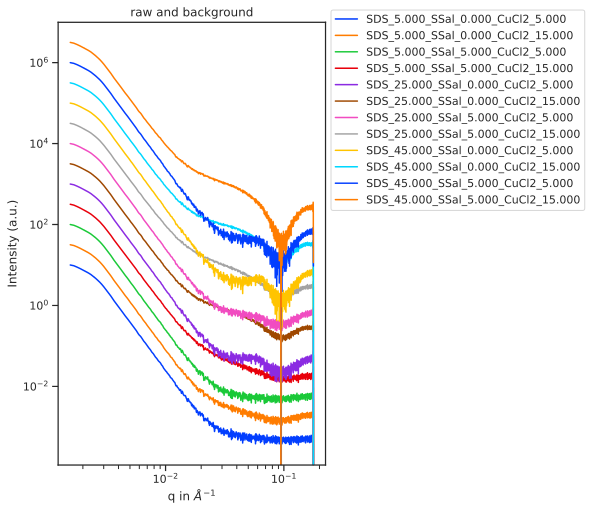

In [58]:
from scipy.signal import savgol_filter as savfilt
fig,ax=plt.subplots(1,1,figsize=(4.8,8))
for i in range(12):
    
    q = ds.q#.sel(q=slice(1e-2,q.max())).values
    I = ds.I[i]#.sel(q=slice(1e-2,q.max())).values
    dI = ds.dI[i]#.sel(q=slice(1e-2,q.max())).values
    name = ds.name[i].values
    
    savepath = f'/mnt/c/Users/drs18/Documents/SAS_view_inputs/{name}q_I_dI.csv'
    arr = np.stack([q,I,dI],axis=1)
    print(arr.shape, name)
    
    np.savetxt(savepath,arr,delimiter=',')
    raw = savfilt(I,window_length=7,polyorder=5)
    raw_norm = (raw - raw.min())/(raw.max()-raw.min())

    ax.loglog(q,raw_norm*10**(0.5*i+1),c=f'C{i}',label=ds.name[i].values)
    # ax.loglog(q,background_norm*10**(0.5*i+1),c=f'C{i}',alpha=0.2,linestyle='--',zorder=-1)

    # ax[1].loglog(q,abs(raw_norm - background_norm)*10**(0.5*i+1),c=f'C{i}')
ax.set(
    xlabel='q in $\AA^{-1}$',
    ylabel='Intensity (a.u.)',
    title='raw and background'
)
ax.legend(bbox_to_anchor=(1.0,1.04),loc='upper left')
# ax[1].set(
#     xlabel='q in $\AA^{-1}$',
#     ylabel='Intensity (a.u.)',
#     title='raw_norm - bkgd_norm'
# )

### initial models SAXS 

In [71]:
import json
sas_output = json.load(open('/mnt/c/Users/drs18/Documents/SAS_view_inputs/Sphere.json'))
list(sas_output['SDS_45.000_SSal_5.000_CuCl2_15.000q_I_dI.csv1708286996.4063928']['fit_params'])

[{'2D_params': ['False'],
  'background': ['False', '0.001', '', '-inf', 'inf', []],
  'chainfit_params': ['False'],
  'data_id': [['SDS_45.000_SSal_5.000_CuCl2_15.000q_I_dI.csv1708286996.4063928']],
  'data_name': [['SDS_45.000_SSal_5.000_CuCl2_15.000q_I_dI.csv']],
  'fitpage_category': ['Sphere'],
  'fitpage_model': ['core_shell_sphere'],
  'fitpage_structure': ['None'],
  'is_batch_fitting': ['False'],
  'is_data': ['True'],
  'magnetic_params': ['False'],
  'model_name': ['core_shell_sphere'],
  'polydisperse_params': ['True'],
  'q_range_max': ['0.177579123482243'],
  'q_range_min': ['0.0317'],
  'q_weighting': ['1'],
  'radius': ['True', '18.422', '0.17457', '0.0', 'inf', []],
  'radius.width': ['False', '0.19832', '', '0', '1', '35', '3', 'gaussian'],
  'scale': ['True', '0.11055', '0.0049449', '0.0', 'inf', []],
  'sld_core': ['False', '7.2', '', '-inf', 'inf', []],
  'sld_shell': ['False', '12.6', '', '-inf', 'inf', []],
  'sld_solvent': ['False', '9.442', '', '-inf', 'inf', [

In [170]:
SAXS_initial_models = [
    {'name':"micelle_core_shell_sphere_1",
     'sasmodel':'core_shell_sphere',
     'fit_params':{
           "scale"                           : {'value':1e-2,                'bounds':(1e-3,1e3)},
            "background"                     : {'value':1e-3,                'bounds':(1e-4,1e1)},
            "radius"                         : {'value':18.422,              'bounds':(1,1e2)},
            "radius_pd"                      : {'value':0.20,                'bounds':(1e-3,0.25)},
            "radius_pd_type"                 : {'value':'gaussian',          'bounds':None},
            "radius_pd_n"                    : {'value':35,                  'bounds':None},
            "thickness"                      : {'value':7.0538,              'bounds':(0,25)},
            "thickness_pd"                   : {'value':0,                   'bounds':None},
            "thickness_pd_type"              : {'value':'gaussian',          'bounds':None},
            "sld_shell"                      : {'value':12.6,                'bounds':None},
            "sld_core"                       : {'value':7.2,                 'bounds':None},
            "sld_solvent"                    : {'value':9.442,               'bounds':None},
     }
    },
    {'name':"power_law_1",
     'sasmodel':'power_law',
     'fit_params': {
            "scale"                          : {'value':1e-6,         'bounds':(1e-12,1e7)},
            "background"                     : {'value':1e-3,         'bounds':(1e-10,1e1)},
            "power"                          : {'value':4,            'bounds':(3.75,4.25)}
        },
    },
    {'name':"wrom-like_core_shell_sphere_1",
     'sasmodel':'core_shell_cylinder',
     'fit_params':{
           "scale"                           : {'value':1e-2,                'bounds':(1e-3,1e3)},
            "background"                     : {'value':1e-3,                'bounds':(1e-4,1e1)},
            "radius"                         : {'value':18.422,              'bounds':(1,1e2)},
            # "radius_pd"                      : {'value':0.20,                'bounds':(1e-3,0.25)},
            # "radius_pd_type"                 : {'value':'gaussian',          'bounds':None},
            # "radius_pd_n"                    : {'value':35,                  'bounds':None},
            "thickness"                      : {'value':7.0538,              'bounds':(0,25)},
            # "thickness_pd"                   : {'value':0,                   'bounds':None},
            # "thickness_pd_type"              : {'value':'gaussian',          'bounds':None},
            "length"                         : {'value':40    ,              'bounds':(40,100)},
            # "length_pd"                      : {'value':0.5,                 'bounds':(0.4,0.5)},
            # "length_pd_type"                 : {'value':'gaussian',          'bounds':None},
            "sld_shell"                      : {'value':12.6,                'bounds':None},
            "sld_core"                       : {'value':7.2,                 'bounds':None},
            "sld_solvent"                    : {'value':9.442,               'bounds':None},
     }
    }
]

### initial Models SANS

In [ ]:
SANS_initial_models = [
    {'name':"latex_sphere_1",
     'sasmodel':'sphere',
     'fit_params':{
           "scale"                           : {'value':1e-7,         'bounds':(1e-10,1e6)},
            "background"                     : {'value':1e-3,         'bounds':(1e-4,1e1)},
            "radius"                         : {'value':500,          'bounds':(1e0,1e4)},
            "radius_pd"                      : {'value':0.03,         'bounds':(1e-3,0.2)},
            "radius_pd_type"                 : {'value':'gaussian',   'bounds':None},
            "radius_pd_n"                    : {'value':15,           'bounds':None},
            "sld"                            : {'value':0.655,        'bounds':None},
            "sld_solvent"                    : {'value':2.74,         'bounds':None},
     }
    },
    {'name':"power_law_1",
     'sasmodel':'power_law',
     'fit_params': {
            "scale"                          : {'value':1e-6,         'bounds':(1e-12,1e7)},
            "background"                     : {'value':1e-3,         'bounds':(1e-10,1e1)},
            "power"                          : {'value':4,            'bounds':(3.75,4.25)}
        },
    },
    {'name':"guinier_porod_1",
     'sasmodel':'guinier_porod',
     'fit_params':{
            "scale"                         : {"value" : 1e-4,           'bounds': (1e-10,1e1)},
            "background"                    : {"value" : 1e-3 ,       'bounds': (1e-4,1e1)},
            "rg"                            : {"value" :1500 ,        'bounds': (1e0,1e4)},
            "s"                             : {"value" : 0 ,          'bounds': None},
            "porod_exp"                     : {"value" : 4 ,          'bounds': (3.8,4.2)}
        },
    },
    {'name':"raspberry_1",
    'sasmodel':'raspberry',
    'params':{
            "scale"                         : {'value':1e-7,        'bounds':(1e-5,1e6)},
            "background"                    : {'value':1e-3,          'bounds':(1e-4,1e1)},
            "sld_lg"                        : {'value':2.74,          'bounds':None},
            "sld_sm"                        : {'value':0.655,         'bounds':None},
            "sld_solvent"                   : {'value':2.74,           'bounds':(1.4,1.6)},
            "volfraction_lg"                : {'value':0.4,           'bounds':(0.2,1.0)},
            "volfraction_sm"                : {'value':0.1,           'bounds':(0.2,1.0)},
            "surface_fraction"              : {'value':0.4,           'bounds':(0.2,1.0)},
            "radius_lg"                     : {'value':1500,          'bounds':(1e0,1e4)},
            "radius_sm"                     : {'value':500,           'bounds':(1e0,1e4)},
            "radius_sm_pd"                  : {'value':0.10,          'bounds':(1e-2,1e0)},
            "radius_sm_pd_type"             : {'value':'gaussian',    'bounds':None},
            "radius_sm_pd_n"                : {'value':15,            'bounds':None},
            "radius_lg_pd"                  : {'value':0.03,          'bounds':(1e-3,1e0)},
            "radius_lg_pd_type"             : {'value':'gaussian',    'bounds':None},
            "radius_lg_pd_n"                : {'value':15,            'bounds':None},
            "penetration"                   : {'value':0,             'bounds':None}
        }
    }
]


### bulk fit

In [192]:
data = []
Is = []
dIs = []
for idx in range(12):
    q = ds.q
    I = ds.I[idx].values[(q>2.5e-2)]
    dI = ds.dI[idx].values[(q>2.5e-2)]
    q = ds.q.values[(q>2.5e-2)]
    Is.append(I.tolist())
    dIs.append(dI.tolist())
# data = sasmodels.data.Data1D(x=q,y=I,dy=dI) 
# initial_models = [
#     {'name':"polymer_micelle_1",
#      'sasmodel':'polymer_micelle',
#      'fit_params':{
#             "scale"       : {'value':2*np.average(Is), 'bounds':(1e-1,1e4)},
#             "background"  : {'value':50,       'bounds':(1e-1,1e4)},
#             "radius_core" : {'value':40,       'bounds':(1e-1,1e4)},
#             "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
#             "sld_core"    : {'value':5.45,     'bounds':None},
#             "sld_corona"  : {'value':5.15,     'bounds':None},
#             "sld_solvent" : {'value':6.36,     'bounds':None},
#      }
#     },
#     {'name':"small_sphere_1",
#      'sasmodel':'sphere',
#      'fit_params':{
#             "scale"       : {'value':np.average(Is),   'bounds':(1e-1,1e4)},
#             "background"  : {'value':20,       'bounds':(1e1,1e2)},
#             "radius"      : {'value':50,       'bounds':(1e-1,1e3)},
#             "radius_pd"   : {'value':0.15,       'bounds':(0.02,0.5)},
#             "radius_pd_type": {'value':'gaussian','bounds':None},
#             "radius_pd_n": {'value':15,'bounds':None},
#             "sld"         : {'value':5.45,     'bounds':None},
#             "sld_solvent" : {'value':6.36,     'bounds':None},
#         }
#     },
#     {'name':"poly_gauss_coil_1",
#      'sasmodel':'poly_gauss_coil',
#      'fit_params':{
#             "i_zero"      : {'value':np.average(Is),   'bounds':(1e-1,1e4)},
#             "background"  : {'value':40,       'bounds':(1e-1,1e4)},
#             "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
#             # "polydispersity": {'value':1,       'bounds':(0.5,2)}
#         }
#     }
# ]
min(q),max(q)

(0.02503390975266815, 0.177579123482243)

In [193]:
sasfit_client.set_config(
    model_inputs=SAXS_initial_models,
    q_range = (min(q),(max(q))),
)

'QD-69d3d104-2e83-4282-9e72-d507bad2da21'

In [194]:
sasfit_client.enqueue(task_name='construct_models')

'QD-335c3031-9f02-4af9-a251-8ae6f77e5226'

In [195]:
sasfit_client.enqueue(task_name='print_model_pointer')

'QD-4c0e061c-2f72-4ad8-aed4-f920ff378fbb'

### batch fitting

In [196]:
fit_method={'method':'lm',
            'steps':1000,
            'ftol': 1.5e-6,
            'xtol': 1.5e-6,
            'verbose':True
           }
data_ID = [f'data_{str(idx+1).zfill(3)}' for idx in range(len(ds.I))]
# sasfit_client.enqueue(task_name="fit_models",data=data,
#                       data_ID=data_ID,
#                      fit_method=fit_method)
sasfit_client.enqueue(
    task_name='fit_models',q=q.tolist(), I=Is, dI=dIs,
    fit_method=fit_method
)

'QD-c3e0b460-75ec-4cdb-a856-6dfeee33bf51'

In [214]:
report_json = sasfit_client.enqueue(task_name='build_report',interactive=True)['return_val']
# report_json['best_fits']

### extract the fit values and uncertainties

In [ ]:
# Y = []
# for i, m_id in enumerate(report_json['best_fits']['model_idx']):
#     if m_id == 0:
#         target = report_json['model_fits'][i][0]['output_fit_params']['radius_core']['value']
#         err = report_json['model_fits'][i][0]['output_fit_params']['radius_core']['error']
#         Y.append([target,err])
#     else:
#         Y.append(None)
# X_train = []
# Y_train = []
# for x, y in zip(X,Y):
    
#     if y != None:
#         X_train.append(x)
#         Y_train.append(y)
# np.array(X_train),np.array(Y_train)
# print(np.hstack((np.array(X_train))
# np.save('regressor_data.npy',np.hstack((np.array(X_train),np.array(Y_train))))

In [185]:
str(ds.name[idx].values).split('_')

['Empty Capillary 2']

In [212]:
X = []
for idx in range(12):
    # print(ds.name[idx].values)
    SDS, SSal, CuCl2 = [str(ds.name[idx].values).split('_')[i] for i in [1,3,5]]
    X.append([SDS, SSal, CuCl2])
print('SDS', 'SSal', 'CuCl2')
X = np.array(X,dtype=float)
X

SDS SSal CuCl2


array([[ 5.,  0.,  5.],
       [ 5.,  0., 15.],
       [ 5.,  5.,  5.],
       [ 5.,  5., 15.],
       [25.,  0.,  5.],
       [25.,  0., 15.],
       [25.,  5.,  5.],
       [25.,  5., 15.],
       [45.,  0.,  5.],
       [45.,  0., 15.],
       [45.,  5.,  5.],
       [45.,  5., 15.]])

## Report pull and reconstituting

Human readable analysis and reporting

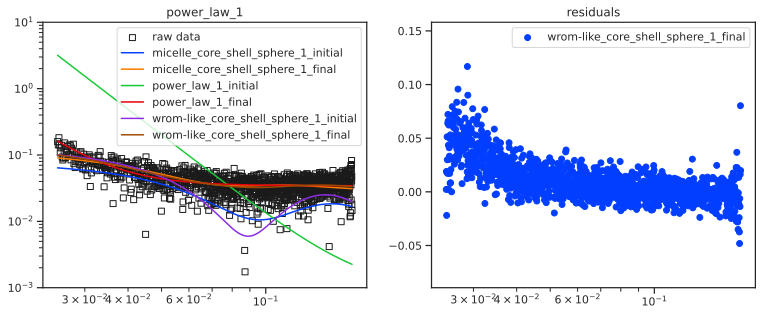

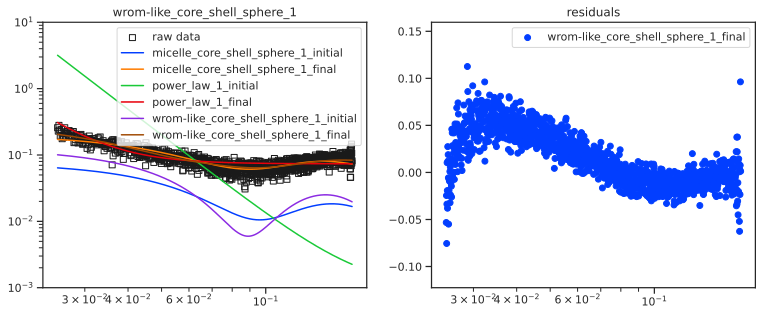

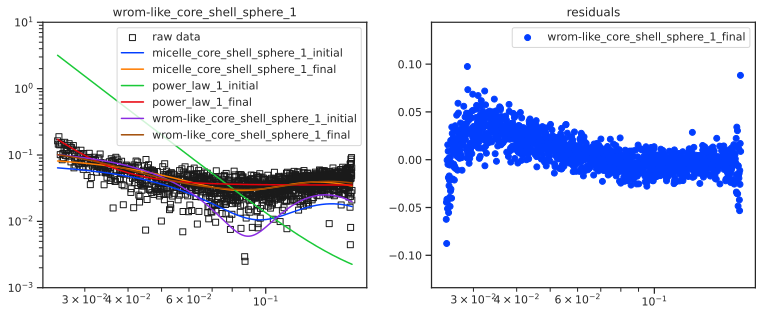

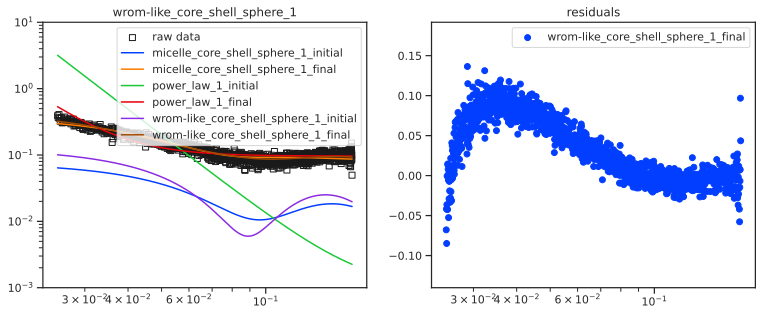

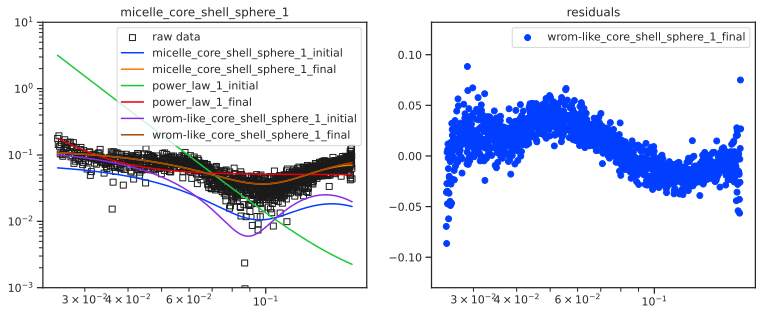

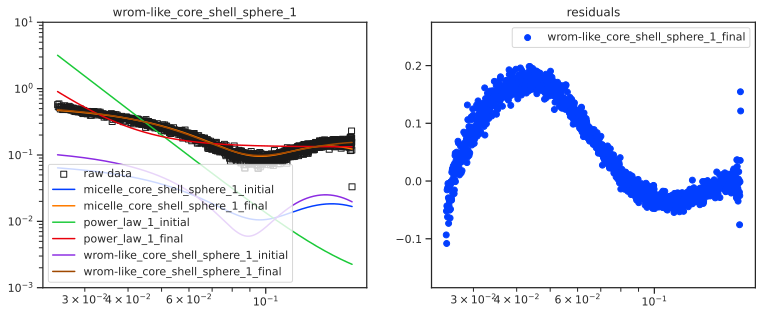

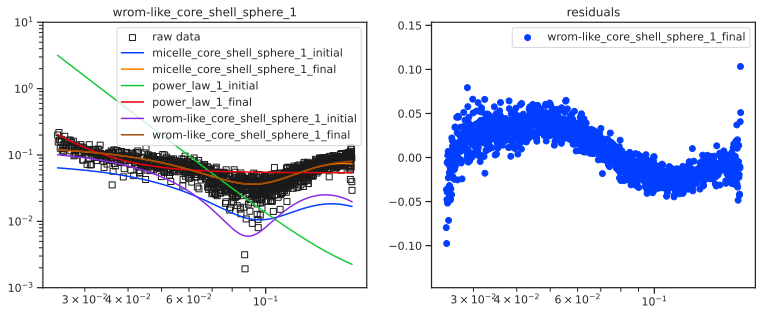

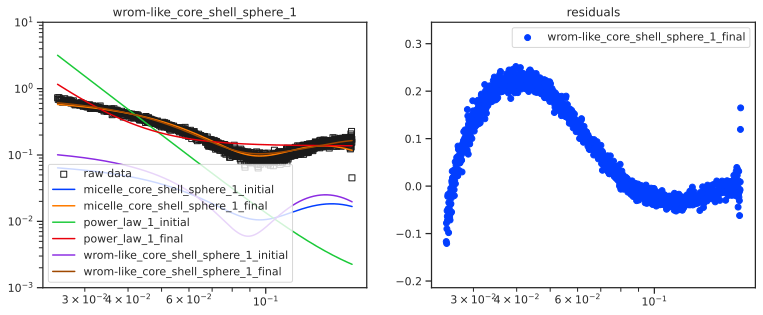

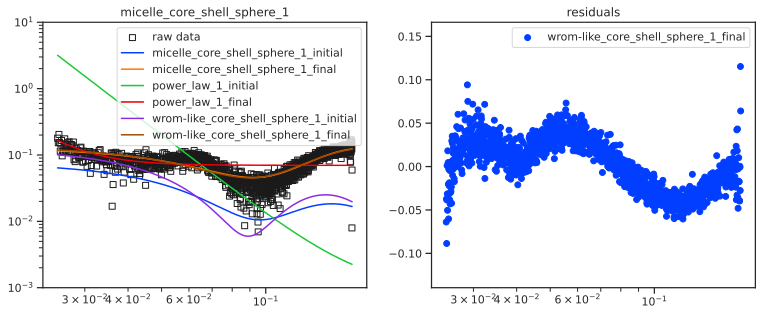

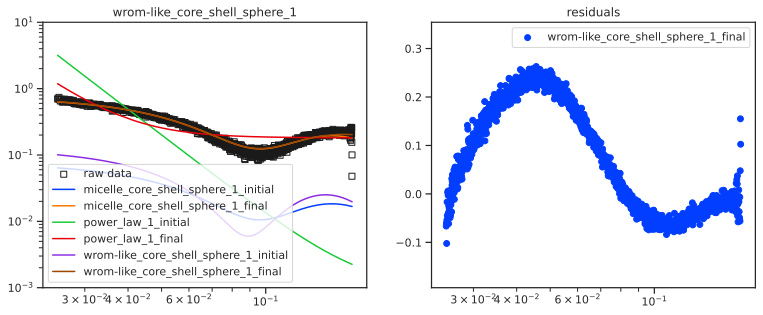

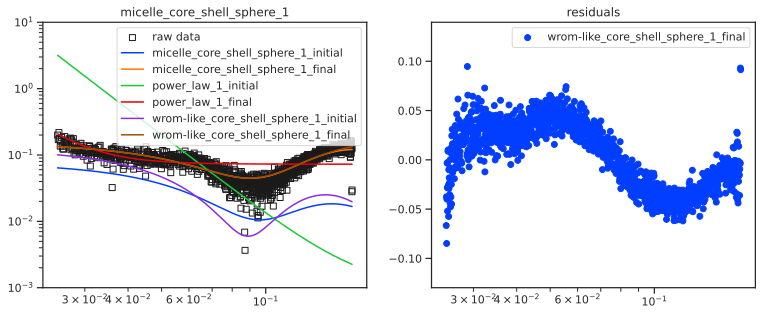

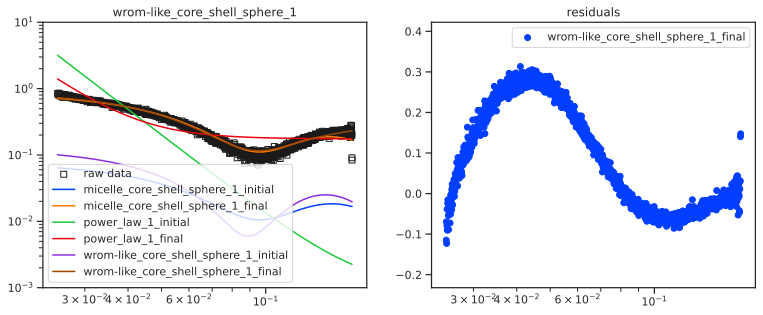

In [230]:
def label_items(arr):
    return np.unique(arr, return_inverse=True)
def label_key(arr):
    return np.unique(arr)

best_fits = []
chisqs = []
# X = []
for idx in range(12):
    
    fit_method={'method':'lm',
                'steps':10000,
                'ftol': 1.5e-6,
                'xtol': 1.5e-6,
                'verbose':True
               }
    
    fit_method= report_json['fit_method']
    print()
    model_starts = report_json['model_inputs']
    fit_results = report_json['best_fits']['model_idx'][idx]
    empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(min(q)),
                                                         np.log10(max(q)),
                                                         len(q)
                                                        ))
    # bf = report_json['best_fits'][f'data_{str(idx+1).zfill(3)}']
    # best_fits.append(bf['model_name'])
    # chisqs.append(bf['lowest_chisq'])
    # best_fits.append(report_json['best_fits'][idx])
    # best_fits.append(fit_results)
    # X.append([model_ds.benzyl_alcohol_solute.values[idx],model_ds.phenol_solute.values[idx]])
    
    
    fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    ax[0].scatter(q,Is[idx],label='raw data',color='k',marker='s',facecolors='none')
    for mdx in range(len(model_starts)):
        init_model = model_starts[mdx]
        fit_model = report_json['model_fits'][idx][mdx]
        # print(init_model)
        # print(fit_model)
        # print()
        init_model = sas_wrapper(
            name=init_model['name'],
            sasmodel_type=init_model['sasmodel'],
            parameters=init_model['fit_params'],
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
            )
        
        #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
        #dictionary this way
        
        params_final = {}
        for key in list(fit_model['output_fit_params']):
            # print(key, fit_model['output_fit_params'][key]['value'])
            params_final[key] = {'value':fit_model['output_fit_params'][key]['value'], 'bounds':None}
        fit_model = sas_wrapper(
            name=fit_model['name'],
            sasmodel_type=fit_model['sasmodel'],
            parameters=params_final,
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
            )
        
        
        ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
        ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
        ax[0].set(
            title = f'{report_json["best_fits"]["model_name"][idx]}',
            xscale='log',
            yscale='log',
            # xlim=(min(q),max(q)),
            ylim= (1e-3,1e1)
            )
        ax[0].legend()
    best_model = report_json['best_fits']['model_params'][idx]
    
    params_final = {}
    for key in list(best_model['output_fit_params']):
        # print(key, fit_model['output_fit_params'][key]['value'])
        params_final[key] = {'value':best_model['output_fit_params'][key]['value'], 'bounds':None}
    
    best_model = sas_wrapper(
        name=best_model['name'],
        sasmodel_type=best_model['sasmodel'],
        parameters=params_final,
        empty_data = empty_data,
        resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )

    residuals = (best_model.model_I - Is[idx])
    spread = (max(residuals) - min(residuals))
    ax[1].scatter(best_model.model_q,residuals, label=f'{fit_model.name}_final')
    ax[1].set(
        title = 'residuals',
        xscale='log',
        # xlim=(min(q),max(q)),
        ylim=(min(residuals)-0.25*spread, max(residuals)+ 0.25*spread)
        )
    ax[1].legend()
    _, clss = label_items(best_fits)
    key = label_key(best_fits)
    # # ax[1] = 
    # ax[1].scatter(np.array(X)[:,0],np.array(X)[:,1],c=clss,cmap='viridis')
    plt.show(fig)
    plt.close(fig)

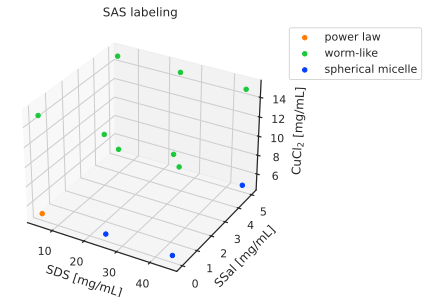

In [231]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
names = ['spherical micelle','power law','worm-like']
for i in range(12):
    model_idx = report_json['best_fits']['model_idx'][i]
    ax.scatter(X[i,0],X[i,1],X[i,2],c=f'C{model_idx}',label=names[model_idx])
    ax.set(
        xlabel='SDS [mg/mL]',
        ylabel='SSal [mg/mL]',
        zlabel='CuCl$_{2}$ [mg/mL]',
        title='SAS labeling'
    )
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique),bbox_to_anchor=(1.04,1.0),loc="upper left")
# ax.legend(np.unique(handles),np.unique(labels))

## test startup and base functions